# Version 4 

L'objectif de cette version est d'utiliser les données historiques et le nouveau cadre de simulation fait en version 3 pour pouvoir implémenter :
1. Un algo ultra basique comme fait en version 2
2. Un algo un peu plus élaboré basé sur le principe du filtre de Kalman

Questionnement :
1. Pas d'interet de faire tourner l'ancien algo car il va forcément bien marcher même sur le nouveau cadre étant donnée que le nombre de seconde dans une journée est connue (horaires fixes d'ouverture des br).
2. Si jamais je devais le faire tourner, ça serait sur les données historiques générées ou faire l'implémentation "en temps réel" en parallèle de la simulation ? 

### Etape 1 - Reprendre le code propre de simulation

In [1]:
import numpy as np
import random 
import simpy
import time
import csv
from collections import namedtuple
from datetime import datetime
import pandas as pd

In [2]:
def panneaux_dispo(nb_heures, total_panneaux):
    prop = np.random.normal(loc=0.8, scale=0.2, size=nb_heures)
    pann_dispo = list(map(lambda x: int(total_panneaux*x if x<=1 else total_panneaux), prop))
    return pann_dispo

In [3]:
def lambda_br(pann_dispo):
    lam = list(map(lambda x: int((1000-x)/50) if x<950 else 1, pann_dispo))
    return lam

In [4]:
def imps():
    lam = int(np.random.normal(loc=4, scale=2, size=1))
    if lam < 1:
        lam = 1
    nb_imp = np.random.poisson(lam)
    return nb_imp

In [5]:
def delai(lam):
    secondes = np.random.poisson(lam)
    
    #Simuler une proba de pb technique (1% de chance d'en avoir un)
    if not random.random() < 0.99:
        secondes = np.random.poisson(lam + 1000)
    return secondes

In [6]:
def total_sec(nb_jours):
    tot = nb_jours * 86400
    return tot

In [7]:
def sauvegarde(liste, nom_de_fichier):
    with open(nom_de_fichier, "w", encoding="utf8") as fichier:
        #Recuperer le nom des colonnes pour la première ligne
        premier, *_ = liste
        ecrivain = csv.DictWriter(fichier, premier._fields)
        ecrivain.writeheader()
        for br in liste:
            # On ecrit chaque ligne comme un ordered dict
            ecrivain.writerow(br._asdict())

In [8]:
def open_rtb(env, P, timestampnow, nb_jours, bidrequests, data):
    dispo = panneaux_dispo(14, 1000)
    lam_secondes = lambda_br(dispo)
    current_hour = datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour
    i = 0
    identifiant = 0
    while True:
        # Déterminer dans quel état on est actuellement
        if current_hour >= 6 and current_hour < 20:
            if setup:
                setup = False
                dispo = panneaux_dispo(14, 1000)
                lam_secondes = lambda_br(dispo)
                current_hour = datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour
                i = 0
            
            # Génération d'une br
            identifiant += 1
            rt = (timestampnow+total_sec(nb_jours))-env.now

            #Timestamp de la br
            time = datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S")

            # Nombre d'impressions
            nb_imp = imps()
            Prix = P * nb_imp

             # Stocker les résultats dans le namedtuple puis ajout à une liste
            resultats = bidrequests(
                identifiant = identifiant,
                timestamp = env.now,
                timestamp_string = time,
                nombre_impressions = nb_imp,
                prix_impression = P,
                prix_total = Prix
            )
            data.append(resultats)

            # Detecter quelle heure est-t-il
            if datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour != current_hour:
                i += 1 
                current_hour = datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour

            # Temps avant la prochaine BR
            # On passe par un try except au cas ou il y a un changement d'heure inattendu sur la fin de période
            try:
                time_before_next = delai(lam_secondes[i])
            except IndexError:
                time_before_next = delai(lam_secondes[i-1])


            # Fin de la simulation
            if rt < time_before_next:
                print(f"Fin de la simulation à {time} !")

            yield env.timeout(time_before_next)
            
        else:
            setup = True
            current_hour = datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour
            time = datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S")
            rt = (timestampnow+total_sec(nb_jours))-env.now
            if rt <= 1:
                print(f"Fin de la simulation à {time} !")
            yield env.timeout(1)  

In [9]:
# Constante 
nb_days = 30
prix_per_imp = 1

In [10]:
timestampnow = int(time.time()-3600*8)
# Générer un named tuple pour stocker les résultats
bidrequests =  namedtuple(
    "bidrequests", 
    (
        "identifiant", 
        "timestamp", 
        "timestamp_string",
        "nombre_impressions",
        "prix_impression",
        "prix_total"
    )
                    )
# Liste pour stocker les résultats du namedtuple
data = list()
env = simpy.Environment(initial_time=timestampnow)
proc = env.process(open_rtb(env, prix_per_imp, timestampnow, nb_days, bidrequests, data))

In [11]:
env.run(until=timestampnow + total_sec(nb_days))

Fin de la simulation à 07-12-2020 03:05:59 !


In [12]:
len(data)

112398

# Algorithme de pacing uniforme 

Pour générer une dépense lissée sur toute la journée, une solution pourrait être de se ramener à un problème d'optimisation sous contrainte. Seulement, dans le cadre du DOOH (enfin il me semble), chaque impression n'est pas quantifiable en terme de qualité. On peut simplement acquérir une impression mais on ne sais pas si c'est une impression de bonne qualité étant donné que nous n'avons pas de données telles que la probabilité de conversion, le teaux de clic, le taux d'action etc etc. 

L'idée est donc de simplement dans un premier temps avoir un algorithme qui fonctionne automatiquement qui a pour but d'acquérir des impressions toute la journée sans générer de "pics" ou de "creux" de dépense (hors problème technique par exemple).

L'algorithme pourrait donc estimer les horaires à laquelle on reçoit des bids requests et selon ces horaires découper la journée en $t$ time slots (en secondes voire encore plus précis) et donc assigner un budget par time slot. 

$$b_{t+1} = \Bigr(B - \sum_{s=1}^{t} S(s)\Bigl) \dfrac{1}{T-t}$$

où $b_{t+1}$ est le budget à allouer à la seconde $t+1$, $B$ le budget total de la journée, $S(s)$ est la dépense effective à la seconde $t$ et enfin $T-t$ représente le temps restant en secondes jusqu'à la fin de la journée.

### On modifie la fonction qui génère les données pour inclure le petit programme de pacing

In [14]:
def open_rtb_pacing(env, P, B, timestampnow, nb_jours, nb_hours_per_day, bidrequests, data):
    setup = True
    identifiant = 0
    cible = B/(nb_hours_per_day*3600)
    current_hour = datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour
    while True:
        # Déterminer dans quel état on est actuellement
        if current_hour >= 6 and current_hour < 20:
            if setup:
                setup = False
                dispo = panneaux_dispo(nb_hours_per_day, 1000)
                lam_secondes = lambda_br(dispo)
                current_hour = datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour
                i = 0
                S = list()
                end_day = env.now + (nb_hours_per_day*3600) #On fixe la fin de la journée à 20h
            
            # Génération d'une br
            identifiant += 1
            rt = (timestampnow+total_sec(nb_jours))-env.now
            
            # Déterminer b_t
            bt = (B - sum(S))/(end_day - env.now) 
            if bt < 0:
                bt=0
            
            #Timestamp de la br
            time = datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S")

            # Nombre d'impressions
            nb_imp = imps()
            Prix = P * nb_imp
            
            #Achat ou non 
            if bt >= cible:
                S.append(Prix)
                achat = 1
            else:
                achat = 0

            # Stocker les résultats dans le namedtuple puis ajout à une liste
            resultats = bidrequests(
                identifiant = identifiant,
                timestamp = env.now,
                timestamp_string = time,
                nombre_impressions = nb_imp,
                prix_impression = P,
                prix_total = Prix,
                achat = achat,
                budget_depense = sum(S),
                bt = bt,
                cible = cible
            )
            data.append(resultats)

            # Temps avant la prochaine BR
            # On passe par un try except au cas ou il y a un changement d'heure inattendu sur la fin de période
            try:
                time_before_next = delai(lam_secondes[i])
            except IndexError:
                time_before_next = delai(lam_secondes[i-1])


            # Fin de la simulation
            if rt < time_before_next:
                print(f"Fin de la simulation à {time} !")

            yield env.timeout(time_before_next)
            
            # Detecter quelle heure est-t-il
            if datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour != current_hour:
                i += 1 
                current_hour = datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour

        else:
            setup = True
            current_hour = datetime.strptime(datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S"), '%m-%d-%Y %H:%M:%S').hour
            time = datetime.fromtimestamp(env.now).strftime("%m-%d-%Y %H:%M:%S")
            rt = (timestampnow+total_sec(nb_jours))-env.now
            if rt <= 1:
                print(f"Fin de la simulation à {time} !")
            yield env.timeout(1) 

In [15]:
# Constante 
nb_days = 30
prix_per_imp = 1
Budget_par_jour = 3000

In [16]:
timestampnow = int(time.time()-3600*5)
# On génère un nouveau name tuple qui prend en compte les variables d'achat, le budget dépensé, le budget par seconde etc
bidrequests =  namedtuple(
    "bidrequests", 
    (
        "identifiant", 
        "timestamp", 
        "timestamp_string",
        "nombre_impressions",
        "prix_impression",
        "prix_total",
        "achat",
        "budget_depense",
        "bt",
        "cible"
    )
                    )
# Liste pour stocker les résultats du namedtuple
data = list()
env = simpy.Environment(initial_time=timestampnow)
proc = env.process(open_rtb_pacing(env, prix_per_imp, Budget_par_jour, timestampnow, nb_days, 14, bidrequests, data))

In [17]:
env.run(until=timestampnow + total_sec(nb_days))

Fin de la simulation à 07-16-2020 05:48:26 !


In [18]:
sauvegarde(data, '16-06-2020_1month.csv')

In [61]:
df = pd.read_csv('test.csv')

In [62]:
df.head(10)

,identifiant,timestamp,timestamp_string,nombre_impressions,prix_impression,prix_total,achat,budget_depense,bt,cible
0,1,1591934401,06-12-2020 06:00:01,1,1,1,1,1,0.059524,0.059524
1,2,1591934403,06-12-2020 06:00:03,4,1,4,0,1,0.059506,0.059524
2,3,1591934411,06-12-2020 06:00:11,3,1,3,0,1,0.059516,0.059524
3,4,1591934428,06-12-2020 06:00:28,2,1,2,1,3,0.059536,0.059524
4,5,1591934439,06-12-2020 06:00:39,0,1,0,0,3,0.059509,0.059524
5,6,1591934446,06-12-2020 06:00:46,7,1,7,0,3,0.059517,0.059524
6,7,1591934452,06-12-2020 06:00:52,5,1,5,1,8,0.059525,0.059524
7,8,1591934461,06-12-2020 06:01:01,7,1,7,0,8,0.059436,0.059524
8,9,1591934470,06-12-2020 06:01:10,2,1,2,0,8,0.059446,0.059524
9,10,1591934477,06-12-2020 06:01:17,7,1,7,0,8,0.059455,0.059524


In [63]:
df.tail(10)

,identifiant,timestamp,timestamp_string,nombre_impressions,prix_impression,prix_total,achat,budget_depense,bt,cible
3873,3874,1591984767,06-12-2020 19:59:27,4,1,4,0,3004,0.0,0.059524
3874,3875,1591984770,06-12-2020 19:59:30,3,1,3,0,3004,0.0,0.059524
3875,3876,1591984775,06-12-2020 19:59:35,5,1,5,0,3004,0.0,0.059524
3876,3877,1591984779,06-12-2020 19:59:39,7,1,7,0,3004,0.0,0.059524
3877,3878,1591984782,06-12-2020 19:59:42,2,1,2,0,3004,0.0,0.059524
3878,3879,1591984788,06-12-2020 19:59:48,5,1,5,0,3004,0.0,0.059524
3879,3880,1591984794,06-12-2020 19:59:54,5,1,5,0,3004,0.0,0.059524
3880,3881,1591984795,06-12-2020 19:59:55,2,1,2,0,3004,0.0,0.059524
3881,3882,1591984798,06-12-2020 19:59:58,2,1,2,0,3004,0.0,0.059524
3882,3883,1591984806,06-12-2020 20:00:06,4,1,4,1,3008,0.8,0.059524


In [65]:
prop = df.achat.sum()*100/len(df)
print(f"On a acheté environ {round(prop,2)}% de bid requests")

On a acheté environ 21.66% de bid requests


In [66]:
df['depense_effective'] =  df['achat']*df['prix_total']

In [67]:
df['Date'] = pd.to_datetime(df['timestamp_string'], errors='coerce')

In [68]:
df

,identifiant,timestamp,timestamp_string,nombre_impressions,prix_impression,prix_total,achat,budget_depense,bt,cible,depense_effective,Date
0,1,1591934401,06-12-2020 06:00:01,1,1,1,1,1,0.059524,0.059524,1,2020-06-12 06:00:01
1,2,1591934403,06-12-2020 06:00:03,4,1,4,0,1,0.059506,0.059524,0,2020-06-12 06:00:03
2,3,1591934411,06-12-2020 06:00:11,3,1,3,0,1,0.059516,0.059524,0,2020-06-12 06:00:11
3,4,1591934428,06-12-2020 06:00:28,2,1,2,1,3,0.059536,0.059524,2,2020-06-12 06:00:28
4,5,1591934439,06-12-2020 06:00:39,0,1,0,0,3,0.059509,0.059524,0,2020-06-12 06:00:39
...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3879,1591984788,06-12-2020 19:59:48,5,1,5,0,3004,0.000000,0.059524,0,2020-06-12 19:59:48
3879,3880,1591984794,06-12-2020 19:59:54,5,1,5,0,3004,0.000000,0.059524,0,2020-06-12 19:59:54
3880,3881,1591984795,06-12-2020 19:59:55,2,1,2,0,3004,0.000000,0.059524,0,2020-06-12 19:59:55
3881,3882,1591984798,06-12-2020 19:59:58,2,1,2,0,3004,0.000000,0.059524,0,2020-06-12 19:59:58


In [69]:
df['hour'] = df['Date'].dt.hour

In [70]:
mean_spending = df.groupby(['hour'])['depense_effective'].mean()

In [71]:
mean_spending = mean_spending[:-1]

In [72]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


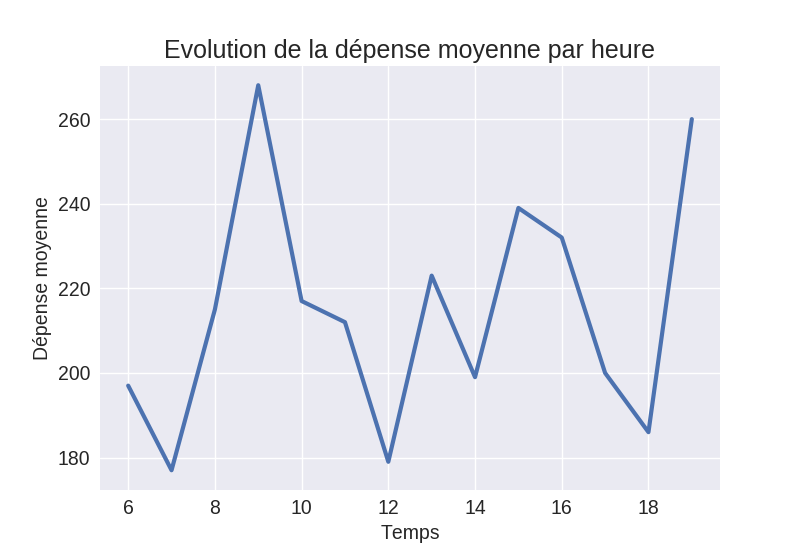

In [73]:
plt.style.use('seaborn')
fig, ax = plt.subplots()
ax.plot(mean_spending, linewidth=3)
# Set chart title and label axes.
ax.set_title("Evolution de la dépense moyenne par heure", fontsize=18)
ax.set_xlabel("Temps", fontsize=14)
ax.set_ylabel("Dépense moyenne", fontsize=14)
# Set size of tick labels.
ax.tick_params(axis='both', labelsize=14)
plt.show()

<IPython.core.display.Javascript object>


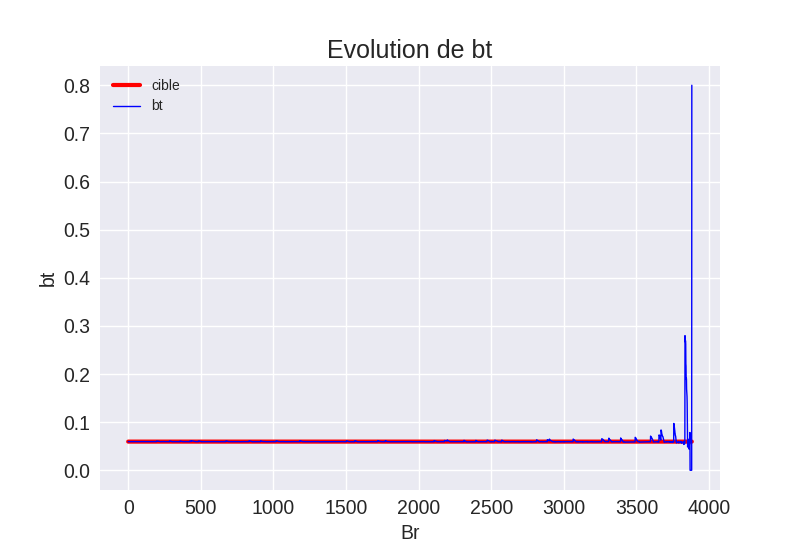

In [86]:
plt.style.use('seaborn')
fig, ax = plt.subplots()
ax.plot(df.cible, linewidth=3, color="red", label='cible')
ax.plot(df.bt, linewidth=1, color="blue", label='bt')
# Set chart title and label axes.
ax.set_title("Evolution de bt", fontsize=18)
ax.set_xlabel("Br", fontsize=14)
ax.set_ylabel("bt", fontsize=14)
# Set size of tick labels.
ax.tick_params(axis='both', labelsize=14)
ax.legend()
plt.show()

### Dépenser tout le budget 

L'algorithme actuel est efficace pour garantir une dépense plutôt uniformisée sur la journée. Cependant en fin de journée, l'algo rencontre beaucoup de difficultés : 

1. S'il n'y a pas assez de bid requests, alors le budget ne sera pas dépensé totalement ce qui est problématique
2. Il y a apparition de gros pics en fin de période que l'on voudrait étaler plutôt sur toute la période

Il faut donc assurer le deuxième objectif de dépenser tout le budget. 

Pour cela, plusieurs idées initiales : 
1. Régles "manuelles" afin d'accélérer la dépense en fin de période 
2. Règles basées sur les proportions d'achat de br -> Si on tend vers 100%, il faut accélérer la dépense
3. Ajuster dynamiquement une estimation du délais entre 2 br (supposé constant dans la journée) afin d'intégrer les phénomènes d'accélération et de ralentissement dans l'arrivée des br

#### Analyse de données historiques

In [35]:
df = pd.read_csv('16-06-2020_1month.csv', index_col="timestamp_string", parse_dates=True)

In [37]:
df.shape

(112143, 9)

In [38]:
df.index.names = ['Date']

In [39]:
df.head()

,identifiant,timestamp,nombre_impressions,prix_impression,prix_total,achat,budget_depense,bt,cible
Date,,,,,,,,,
2020-06-16 06:00:01,1,1592280001,2,1,2,1,2,0.059524,0.059524
2020-06-16 06:00:02,2,1592280002,4,1,4,0,2,0.059485,0.059524
2020-06-16 06:00:03,3,1592280003,1,1,1,0,2,0.059486,0.059524
2020-06-16 06:00:03,4,1592280003,6,1,6,0,2,0.059486,0.059524
2020-06-16 06:00:03,5,1592280003,1,1,1,0,2,0.059486,0.059524


In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

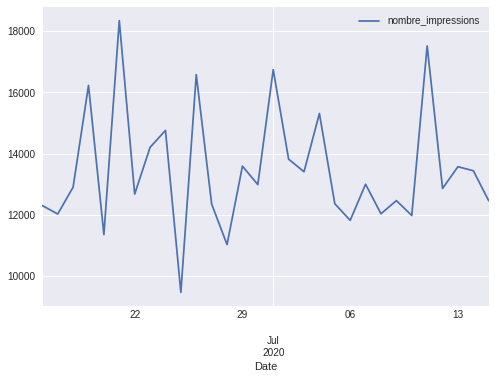

In [50]:
test.resample('D').sum().plot()